# Highpass filter using Dask array

### This code applies a high-pass filter to a 3D xarray.DataArray (e.g., sea level anomaly) along its time dimension, using the Butterworth filter from SciPy.

##### The code employs Dask to efficiently handle large datasets by breaking them into smaller, manageable chunks that can be processed in parallel. This is particularly useful for high-resolution 3D datasets (e.g., daily gridded sla data) where dimensions like time, latitude, and longitude may span millions of data points, exceeding the memory capacity of a typical system.


##### Load modules

In [74]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec

##### Load data

In [123]:
ds=xr.open_dataset('../data/IO_daily_sla-2000.nc')
sla=ds.sla # daily sea level anomaly   # unit meter
sla=sla*100 # making unit to cm

In [124]:
# Data details
sla.dims,sla.shape,sla.attrs

(('time', 'latitude', 'longitude'), (366, 192, 240), {})

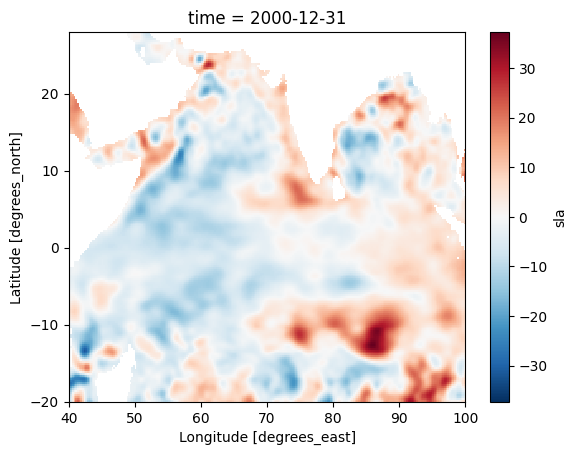

In [128]:
sla[-1].plot() # plot last time step

#### Function for highpass filtering of a daily time series.

 ##### The filtered data removes low-frequency variations with periods longer than  cutoff (here 30) days. 

In [129]:

import xarray as xr
import numpy as np
from scipy.signal import butter, filtfilt

# Define the high-pass filter function
def highpass_filter(data, cutoff, fs, order=5):
    """
    High-pass filter for 1D time series data.
    Args:
    - data: The input data (1D time series).
    - cutoff: The cutoff frequency in days.
    - fs: Sampling frequency (e.g., 1/day for daily data).
    - order: Order of the filter.
    Returns:
    - Filtered data.
    """
    nyquist = 0.5 * fs
    normal_cutoff = 1 / cutoff / nyquist  # Convert days to frequency
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

####  Function for high pass filtering of a 3D data along time axis using dask array opearation [here SLA is 3D {time,lat,lon}]

##### 1) Give cut off frequency
##### 2) check sampling frequency

In [130]:
# Parameters
cutoff = 30  # 30-day cutoff           
fs = 1       # Sampling frequency (1/day)

data_=sla

# Apply the high-pass filter to the xarray.DataArray
HP_filtered_sla = xr.apply_ufunc(
    highpass_filter,
    data_,
    input_core_dims=[['time']],  # Operates along 'time' dimension
    output_core_dims=[['time']],  # Output retains the 'time' dimension
    kwargs={'cutoff': cutoff, 'fs': fs, 'order': 5},  # Scalar arguments order: Order of the filter.
    vectorize=True,  # Applies the function across all other dimensions
    dask='allowed',  # Allows Dask arrays (if applicable)
)

HP_filtered_sla = HP_filtered_sla.transpose('time', 'latitude', 'longitude') # Reorder dimensions to (time, latitude, longitude)

##### In the function xr.apply_ufunc, the parameter dask='allowed' is specified, enabling Dask compatibility.
##### This allows the filtering operation to be performed on lazy-loaded chunks of data, improving computational efficiency without loading the entire dataset into memory.

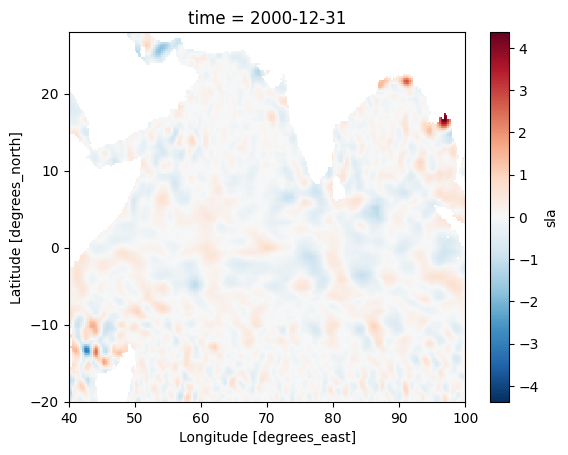

In [139]:
HP_filtered_sla[-1].plot() 

##### Plot the original and filtered data over the area averaged data

Text(0, 0.5, 'sla (cm)')

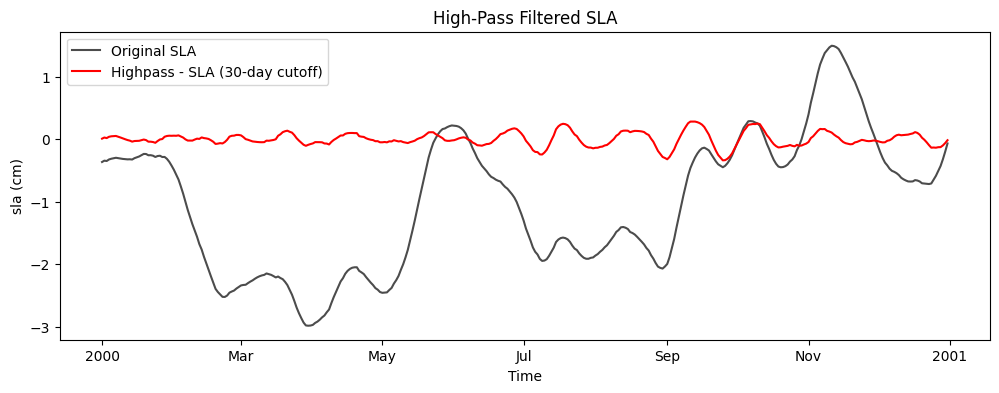

In [133]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
xx_=60
yy_=25

sla.mean(dim=['latitude','longitude']).plot(label='Original SLA', alpha=0.7,color='k')
HP_filtered_sla.mean(dim=['latitude','longitude']).plot(label='Highpass - SLA ('+str(cutoff)+'-day cutoff)',color='r')

plt.legend()
plt.title('High-Pass Filtered SLA')
plt.ylabel('sla (cm)')

 ##### Let's check the power spectra

In [141]:
# Define a function to compute the power spectrum
def compute_fft(data, time_dim='time'):
    """
    Compute the power spectrum of a time series.
    Args:
    - data: xarray.DataArray with time as one of the dimensions.
    - time_dim: The name of the time dimension.
    Returns:
    - freqs: Frequencies (1/days).
    - power: Power spectrum of the signal.
    """
    time = data[time_dim]
    #dt = (time[1] - time[0]).astype('timedelta64[s]').item() / (24 * 3600)  # Time step in days for sec data
    dt=1
    n = len(time)
    
    # Compute FFT
    fft_result = np.fft.fft(data)
    power = np.abs(fft_result)**2 / n  # Power spectrum
    freqs = np.fft.fftfreq(n, d=dt)   # Frequencies in 1/days
    
    return freqs[:n // 2], power[:n // 2]  # Return positive frequencies and power

In [142]:
original_signal = sla.mean(dim=['latitude','longitude'])
filtered_signal = HP_filtered_sla.mean(dim=['latitude','longitude'])

# Compute FFT for original and filtered signals
freqs_original, power_original = compute_fft(original_signal)
freqs_filtered, power_filtered = compute_fft(filtered_signal)

plot

/tmp/ipykernel_24680/3906232717.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freqs_original, power_original, label='Original Signal', alpha=0.7,color='k')
/tmp/ipykernel_24680/3906232717.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freqs_filtered, power_filtered, label='Filtered Signal', alpha=0.7)


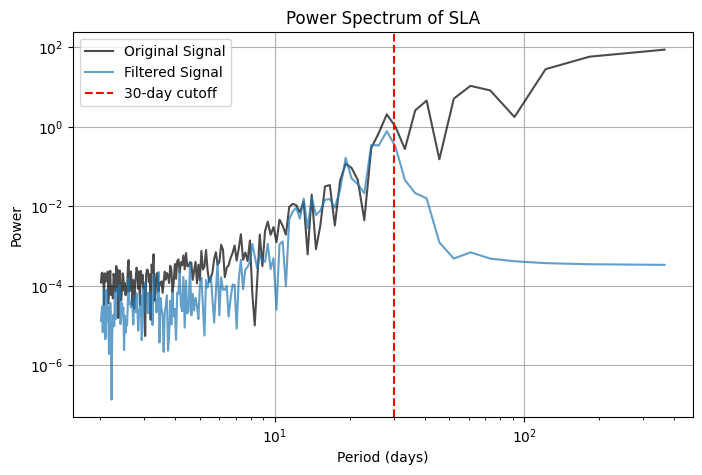

In [143]:
# Plot the power spectra
plt.figure(figsize=(8, 5))
plt.plot(1 / freqs_original, power_original, label='Original Signal', alpha=0.7,color='k')
plt.plot(1 / freqs_filtered, power_filtered, label='Filtered Signal', alpha=0.7)
plt.axvline(cutoff, color='red', linestyle='--', label=str(cutoff)+'-day cutoff')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.yscale('log')  # Log scale for better visualization
plt.xscale('log')  
plt.title('Power Spectrum of SLA')
plt.legend()
plt.grid(True)
plt.show()

##### While the Butterworth filter is typically designed to minimize phase distortion, edge effects can still result in some misrepresentation near the boundaries of the time series.